## Creating plots of TS density, grouped plots for sinking

This notebook will finalize diagrams for the thesis to insure that all use the same grouping of elements. This will slice the dataframe by one year and add the diagrams.

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg
import descartes

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.feature as cfeature
#from xgcm import Grid

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

import time

from scipy.interpolate import interpn

# for the lines
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

### Slice the points by one year, load the release points, load the dataframe for KMeans

In [2]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

### Select by release in polynya (optional)

In [3]:
pts = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/points.txt",sep=",").reshape(391,2)               # points where released

### Or load from file

In [3]:
#wmt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt_final.txt",sep=",")
#wmt = wmt.reshape((35040,6586))
wmt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/mass_wmt.txt",sep=",")
wmt = wmt.reshape((35040,-1))

In [6]:
unique_elements, counts_elements = np.unique(wmt[-1], return_counts=True)
counts_elements

array([1717, 1953,  455,   89, 1835,  478,   59])

In [7]:
# write these to files? does this save time
xgrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/xgrid.txt",sep=",")
ygrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/ygrid.txt",sep=",")

xgrid = xgrid.reshape((35040,6586))
ygrid = ygrid.reshape((35040,6586))

In [11]:
temp = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/temp.txt",sep=",")
salt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/salt.txt",sep=",")
depth = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/depth.txt",sep=",")
temp = temp.reshape((35040,6586))
depth = depth.reshape((35040,6586))
salt = salt.reshape((35040,6586))

In [ ]:
# dens = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/dens.txt",sep=",")
# dens = dens.reshape((35040,7102))

### Other setup conversions, load WM definitions

In [8]:
group1 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group3_6586.txt",sep=",")
group2 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group1_6586.txt",sep=",")
group3 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group6_6586.txt",sep=",")
group4 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group2_6586.txt",sep=",")
group5 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group4_6586.txt",sep=",")
group6 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group5_6586.txt",sep=",")

group1 = group1.tolist()
group1 = [int(x) for x in group1]
group2 = group2.tolist()
group2 = [int(x) for x in group2]
group3 = group3.tolist()
group3 = [int(x) for x in group3]
group4 = group4.tolist()
group4 = [int(x) for x in group4]
group5 = group5.tolist()
group5 = [int(x) for x in group5]
group6 = group6.tolist()
group6 = [int(x) for x in group6]

groups = np.array([group1,group2,group3,group4,group5,group6],dtype=object)

In [9]:
print(len(group1),len(group2),len(group3),len(group4),len(group5),len(group6))

1687 2907 552 695 412 333


In [12]:
# convert the waom values to gsw values
# convert depth to sea pressure
long = 73.5089
lat = -66.8245
p = gsw.p_from_z(z=depth,lat=-66.8245)


# convert the absolute salinity from practical salinity
SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# find the potential density from SA, CT, p
rho_pot = gsw.rho(SA,CT,p) - 1000

p0 = np.zeros(depth.shape)
SA0 = gsw.SA_from_SP(salt,p0,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT0 = gsw.CT_from_pt(SA0,temp)   # conservative T from potential T
rho_pot0 = gsw.rho(SA0,CT0,p0) - 1000

## Density, Residence Time

In [10]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [14]:
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values

# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

In [11]:
# residence time
import time
# create an empty array for the bin time
m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
    m2.append(newl)
    
# each bin has an average or total time that any one particle spends in it
# for each column
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(5):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)

0 of 6586 in 2.6861826578776044e-06
1000 of 6586 in 0.3641652186711629
2000 of 6586 in 0.7239993572235107
3000 of 6586 in 1.0848703463872273
4000 of 6586 in 1.4470930099487305
5000 of 6586 in 1.8120798587799072
6000 of 6586 in 2.1749197681744894


In [12]:
# create the density map
x_sing = np.array([])
y_sing = np.array([])
start_time = time.time()
for col in range(x_new.shape[1]):
    if col % 500 == 0:
        print(col,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # create a set of datapoints
    thisx = (x_new[:,col])
    thisy = (y_new[:,col])
    
    # create the array of the colum
    arr = np.vstack((thisx,thisy))
    arr = arr.T
    
    # create a set from the array so each coordinate visits each grid square once
    set_coords = list(set(map(tuple,arr)))
    for myset in set_coords:
        x_sing = np.append(x_sing,myset[0])
        y_sing = np.append(y_sing,myset[1])
        
pts = np.vstack((x_sing,y_sing))
pts = pts.T

# normalize to the total number of particles
counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
num_positions = len(counts)
#print(counts)
print(num_positions)

# pop the nan values
counts.pop()

# we are dividing by the number of particles, not number of positions


0 of 6586 in 1.6013781229654948e-06
500 of 6586 in 0.23289423783620197
1000 of 6586 in 0.5562146464983623
1500 of 6586 in 1.3380431612332662
2000 of 6586 in 2.5068116346995035
2500 of 6586 in 3.8600963870684306
3000 of 6586 in 5.563969592253367
3500 of 6586 in 8.464408751328786
4000 of 6586 in 12.262651817003887
4500 of 6586 in 16.593795116742452
5000 of 6586 in 21.50038861433665
5500 of 6586 in 27.003904604911803
6000 of 6586 in 33.47864610354106
6500 of 6586 in 40.410848661263785
6924
7102


In [13]:
num_particles = 6586
print(num_particles)

6586


In [14]:
mesh = np.zeros((len(xbins),len(ybins)))

for ii in counts[:-1]:
    iind = ii[0][0]
    jind = ii[0][1]
    # create the mesh without the scaling by time
    myval = ii[1]/num_particles
    
    # scale by time for one day
    myval = (myval/900)*86400
    
    mesh[int(iind)][int(jind)] = myval

[Xbins, Ybins] = np.meshgrid(ybins,xbins)

# # transform the Ybins and Xbins into lat/long points
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

In [15]:
# AVERAGE MESH
avgmesh = np.zeros((len(xbins),len(ybins)))
slimit = 5

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>slimit:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                avgmesh[ii][jj] = avg

# STDEV MESH - MAKE THIS ONLY FOR BINS WITH >5 FLOATS, ELSE NPNAN
# set a value to see if we want to limit the bin size for zdev
mesh_std = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>slimit:
            std = np.std(m2[ii][jj])
            mesh_std[ii][jj] = std

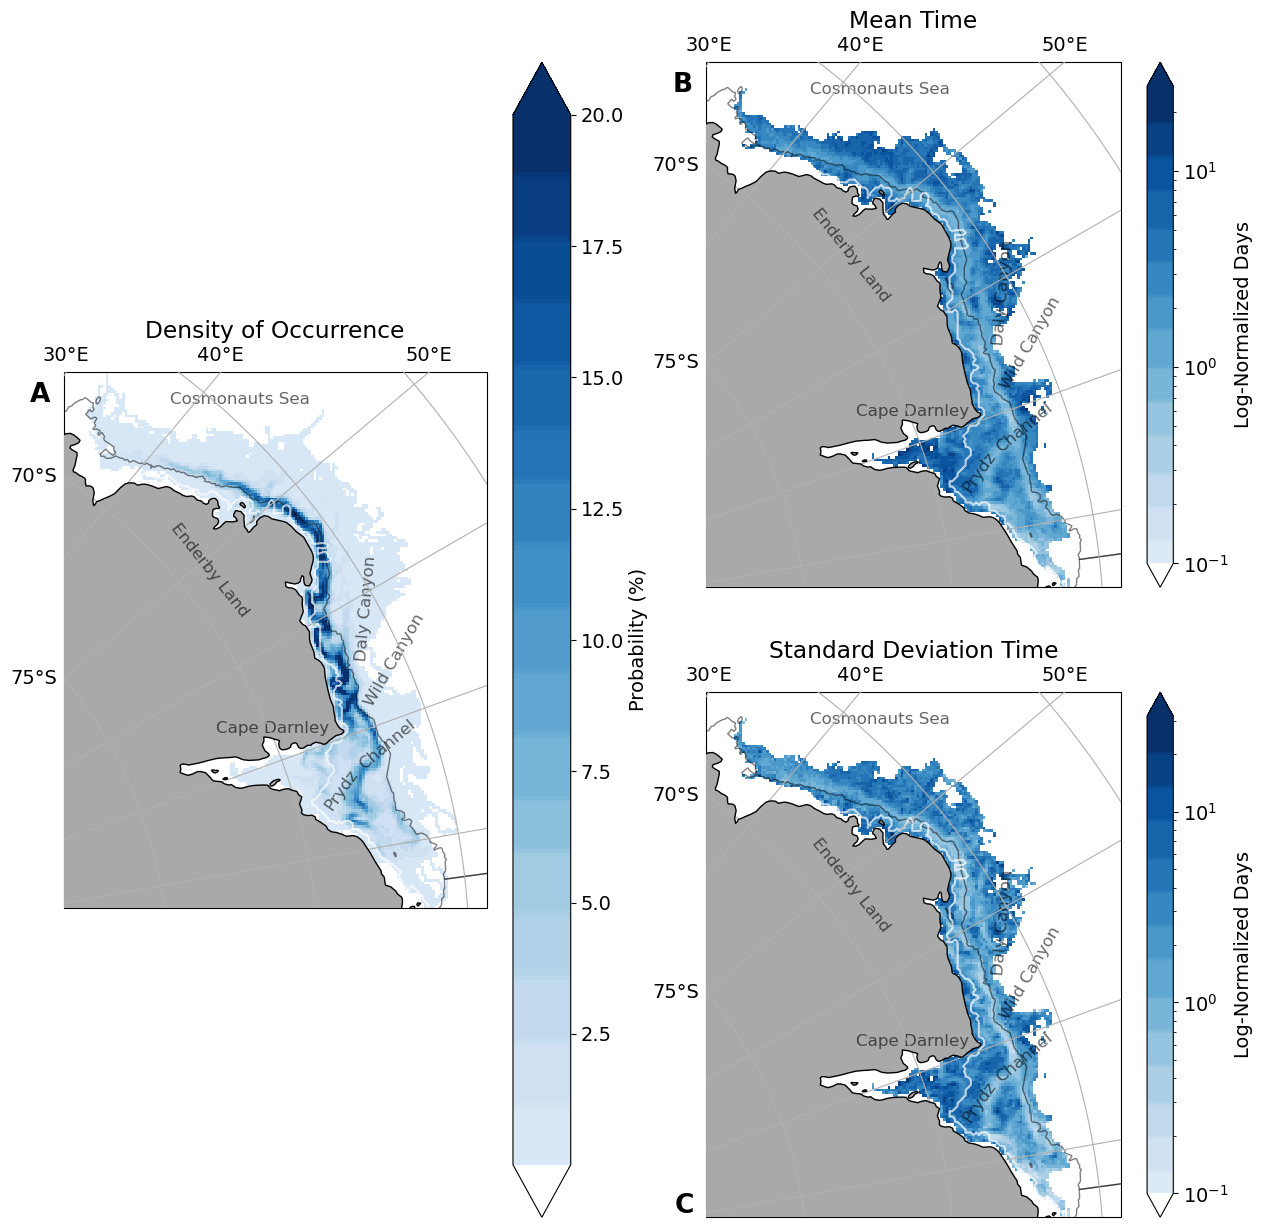

In [28]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
plt.rcParams.update({'font.size': 14})

############################################################
# density map
# setup
ax = plt.subplot2grid((4, 2), (0, 0), rowspan=4,projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = plt.get_cmap('Blues',20).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,mesh,transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.01,vmax=20)
# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
# labels
plt.title("Density of Occurrence")
cbar = plt.colorbar(label="Probability (%)",extend='both')
plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.6)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.6)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.6)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.6)
plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.6)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.6)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.6)
plt.text(x=28.5,y=-68.5,s="A",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")


############################################################
# average values
ax = fig.add_subplot(222, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])
cmap = mpl.cm.get_cmap("Blues",16).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,avgmesh,
               norm=colors.LogNorm(vmin=10e-2,vmax=avgmesh[420:580,300:530].max()),
               transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Mean Time")
cbar = plt.colorbar(label="Log-Normalized Days",extend='both')
plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.6)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.6)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.6)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.6)
plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.6)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.6)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.6)
plt.text(x=28.5,y=-68.5,s="B",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

############################################################
# stdev values
ax = fig.add_subplot(224, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1290000,2900000])
plt.ylim([210000,2250000])

# log scaling
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
            zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
plt.pcolormesh(long,lat,mesh_std,
               norm=colors.LogNorm(vmin=10e-2,vmax=mesh_std[420:580,300:530].max()),
               transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

# latlong ticks
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

# labels
plt.title("Standard Deviation Time")
cbar = plt.colorbar(label="Log-Normalized Days",extend='both')
plt.text(x=52, y=-71,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.6)
plt.text(x=64.9, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.6)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.6)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.6)
plt.text(x=64.2, y=-66.5,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.6)
plt.text(x=68, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.6)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.6)
plt.text(x=79,y=-79.4,s="C",transform=ccrs.PlateCarree(),fontsize=19,weight="bold")

############################################################
fig.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/4diags_polynya_slim5.png',dpi=300)

In [29]:
# ############################################################
# # density map

# # log scaling for density map if of interest later
# ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.5)
# plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.1],
#             zorder=2,linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary,alpha=0.7)
# plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],
#                norm=colors.LogNorm(vmin=10e-3,vmax=mesh[420:580,300:530].max()),
#                transform=ccrs.PlateCarree(),zorder=1,cmap=cmap)

## Polygons and TS diagrams

In [30]:
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti1 = np.linspace(-3,3.3,ydim)
si1 = np.linspace(31,38,xdim)
Freez_temp = gsw.CT_freezing(si1,0,0)

Si, Ti = np.meshgrid(si1, ti1, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si1[i],ti1[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

# convert to practical/potential
long = 73.5089
lat = -66.8245
ti = gsw.pt_from_CT(si1,ti1)
si = gsw.SP_from_SA(si1,0,long,lat)

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 38.38


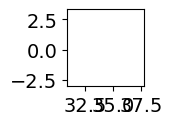

In [31]:
# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the dens2ity vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,36,36,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
aabw = c.intersection(d)

# find the winter water values
cs = ax.contourf(si, ti, dens2, levels=[27.55,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1.5,-1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
ww = a.intersection(b)

# find the mcdw values
cs = ax.contourf(si, ti, dens2, levels=[27.73,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# find the dsw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# ftmax = Freez_temp+0.1
# ftmin = Freez_temp-0.5
# ft = np.append(ftmax,np.flip(ftmin))
# si2 = si.copy()
# si2 = np.append(si2,np.flip(si2))
# b = np.array([[a,b] for a,b in zip(si2,ft)])
sx = np.array([35,35,31,31])
sy = np.array([-3,-1.7,-1.7,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
#dsw = b.intersection(c)
dsw = b.intersection(a)

# find the aasw values
cs = ax.contourf(si, ti, dens2, levels=[24,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.5,34.5,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# find the msw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp + 0.1
ft = np.append(ft,[-0.4,-0.4])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
#dsw = b.intersection(c)
msw = c.intersection(a)
msw = msw.difference(dsw)

# add ISW values
cs = ax.contourf(si, ti, dens2, levels=[25,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
isw = b.intersection(a)
#isw = isw.difference(dsw)
isw = isw.difference(aabw)
#ucdw = ucdw.difference(mcdw)
aasw = aasw.difference(ww)
#aasw = aasw.difference(ucdw)

# find the aaiw values
cs = ax.contourf(si, ti, dens2, levels=[27.2,27.4],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.6,34.6,32,32])
sy = np.array([2,3.5,3.5,2])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aaiw = d.intersection(a)

In [32]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


In [33]:
# saltflat = salt.flatten()
# tempflat = temp.flatten()

### Making a mesh for the density plot

In [34]:
heatmap, xedges, yedges = np.histogram2d(salt.flatten(), temp.flatten(), bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
C = heatmap.T/len(salt.flatten())

In [36]:
X = np.arange(xedges[0], xedges[-1],(xedges[-1]- xedges[0])/101)
Y = np.arange(yedges[0], yedges[-1],(yedges[-1]- yedges[0])/101)
X.shape

(101,)

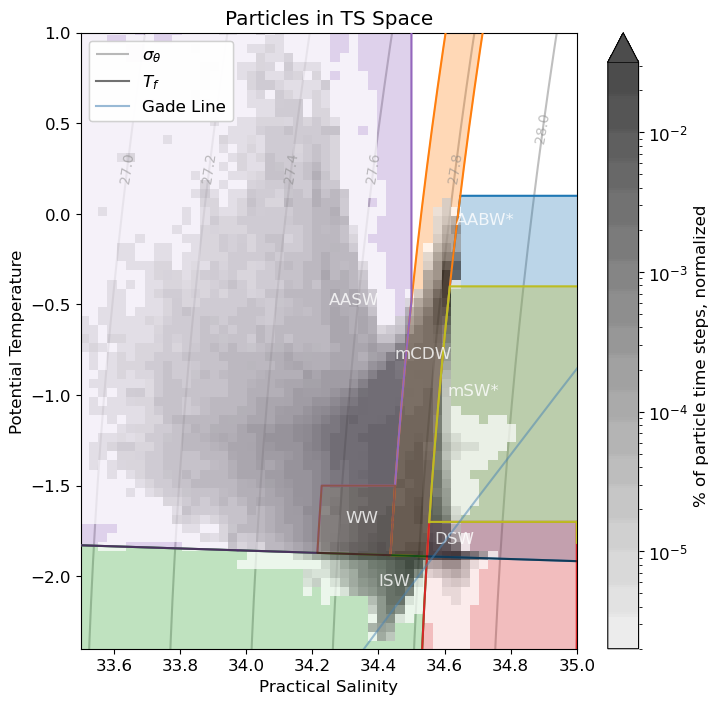

In [39]:
#POLYGONS
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-2.4,1)
plt.xlim(33.5,35)
#plt.xlim(xedges[0], xedges[-1])
#plt.ylim(yedges[0], yedges[-1])
shapes = np.array([])
shapelabels = np.array([])
plt.rcParams.update({'font.size': 12})

# get the colormap
cmap = plt.get_cmap('gray_r',20).copy()
cmap = truncate_colormap(cmap, 0.1)
cmap.set_under(color='white')

# add the potential density lines
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(24,28.5,0.2))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# add the freezing temperature
fline = plt.plot(si,Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=7)
gadeline = plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=8)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")
h = np.append(h,gadeline)
l = np.append(l,"Gade Line")

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW*",color="tab:olive",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW",color="tab:brown",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=2)
plt.gca().add_artist(legend1)
#plt.legend(shapes,shapelabels, loc=1)

# plt.title("Neutral and potential density of water masses")
plt.title("Particles in TS Space")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

s = np.array([34.6,34.6])
t = np.array([1,-0.6])
#plt.scatter(s,t)

# add the labels
plt.text(x=34.61, y=-1,s="mSW*",fontsize=12,alpha=0.8,zorder=5,color="white")
plt.text(x=34.635, y=-0.06,s="AABW*",fontsize=12,alpha=0.8,zorder=5,color="white")
plt.text(x=34.57, y=-1.82,s="DSW",fontsize=12,alpha=0.8,zorder=5,color="white")
plt.text(x=34.45, y=-0.8,s="mCDW",fontsize=12,alpha=0.8,zorder=5,color="white")
plt.text(x=34.25, y=-0.5,s="AASW",fontsize=12,alpha=0.8,zorder=5,color="white")
plt.text(x=34.3, y=-1.7,s="WW",fontsize=12,alpha=0.8,zorder=5,color="white")
plt.text(x=34.4, y=-2.05,s="ISW",fontsize=12,alpha=0.8,zorder=5,color="white")

#plt.scatter(saltflat,tempflat,s=0.05,marker='o',color="black",alpha=0.3)
pcm = ax.pcolormesh(X, Y, C,norm=colors.LogNorm(vmin=2e-6, vmax=C.max()),cmap=cmap,alpha=0.7)
fig.colorbar(pcm, ax=ax, extend='max',label="% of particle time steps, normalized")

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/TS_polynya_cropped.png", dpi=300)
plt.show()

### Create TS multipath plot

In [78]:
# CREATING A MEAN SCATTER OF THE LAST 6 MONTHS
# FIRST GET THE VALUES FROM 6 MONTHS
tests1 = np.mean(salt[:,group1].reshape(60,584,len(group1)),axis=1)    # 6 day average
testt1 = np.mean(temp[:,group1].reshape(60,584,len(group1)),axis=1)

tests2 = np.mean(salt[:,group2].reshape(60,584,len(group2)),axis=1)
testt2 = np.mean(temp[:,group2].reshape(60,584,len(group2)),axis=1)

tests3 = np.mean(salt[:,group3].reshape(60,584,len(group3)),axis=1)
testt3 = np.mean(temp[:,group3].reshape(60,584,len(group3)),axis=1)

tests4 = np.mean(salt[:,group4].reshape(60,584,len(group4)),axis=1)
testt4 = np.mean(temp[:,group4].reshape(60,584,len(group4)),axis=1)

tests5 = np.mean(salt[:,group5].reshape(60,584,len(group5)),axis=1)
testt5 = np.mean(temp[:,group5].reshape(60,584,len(group5)),axis=1)

tests6 = np.mean(salt[:,group6].reshape(60,584,len(group6)),axis=1)
testt6 = np.mean(temp[:,group6].reshape(60,584,len(group6)),axis=1)

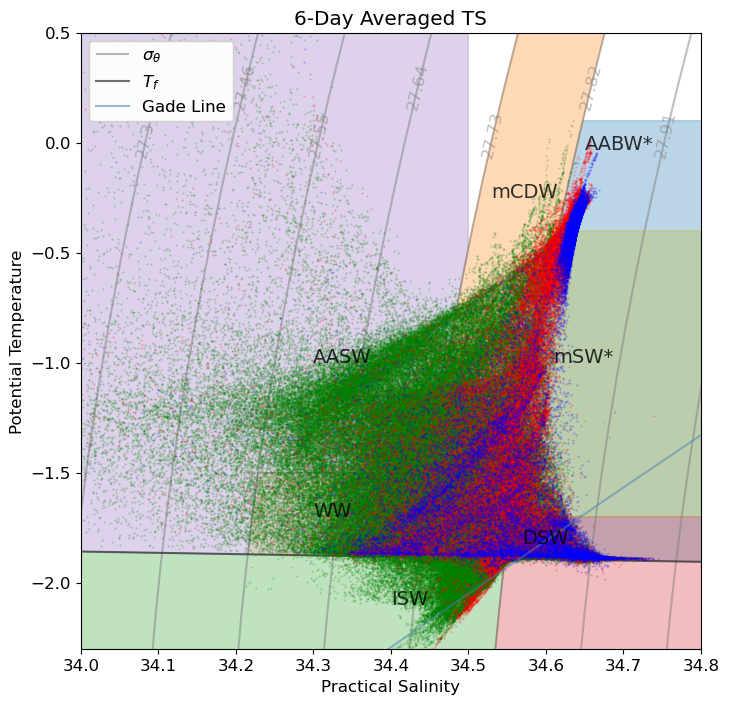

In [141]:
#POLYGONS
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
# plt.ylim(-2.4,max(ti))
# plt.xlim(32,34.8)
plt.ylim(-2.3,0.5)
plt.xlim(34,34.8)
shapes = np.array([])
shapelabels = np.array([])

plt.rcParams.update({'font.size': 12})

# add the neutral density lines
# cs = ax.contour(si, ti, dens_neut,colors="black", zorder=1,alpha=0.5,linestyles='-.')
# cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
# a,b = cs.legend_elements()
# a = np.array([a[0]],dtype=object)
# b = np.array(["$\gamma$"])
# h = np.append(h,a[0])
# l = np.append(l,b[0])

# add the freezing temperature
#Freez_temp = gsw.CT_freezing(np.linspace(31,35,xdim),0,0)
fline = plt.plot(si,Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=3)
gadeline = plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=4)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")
h = np.append(h,gadeline)
l = np.append(l,"Gade Line")

# AABW values
x, y = aabw.exterior.xy
#aabw2 = plt.plot(x, y,label="AABW",color="tab:blue")
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
#mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange")
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
#isw2 = plt.plot(x, y,label="ISW",color="tab:green")
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
#dsw2 = plt.plot(x, y,label="DSW",color="tab:red")
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
#msw2 = plt.plot(x, y,label="mSW*",color="tab:olive")
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
#aasw2 = plt.plot(x, y,label="AASW",color="tab:purple")
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
#ww2 = plt.plot(x, y,label="WW",color="tab:brown")
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=2)
plt.gca().add_artist(legend1)
#plt.legend(shapes,shapelabels, loc="best")

# plt.title("Neutral and potential density of water masses")
plt.title("6-Day Averaged TS")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

# plt.scatter(yfit0,xfit0,s=0.5,marker='o',color="red",label="Group 1")
# plt.scatter(yfit1,xfit1,s=0.5,marker='o',color="orange",label="Group 2")
# plt.scatter(yfit2,xfit2,s=0.5,marker='o',color="blue",label="Group 3")
# plt.scatter(yfit3,xfit3,s=0.5,marker='o',color="purple",label="Group 4")
# plt.scatter(yfit4,xfit4,s=0.5,marker='o',color="blue",label="Group 5")
# plt.scatter(yfit5,xfit5,s=0.5,marker='o',color="purple",label="Group 6")

plt.scatter(tests1,testt1,s=0.2,marker='o',color="green",label="Group 1",alpha=0.3,zorder=3)
plt.scatter(tests2,testt2,s=0.2,marker='o',color="green",label="Group 2",alpha=0.3,zorder=3)
plt.scatter(tests3,testt3,s=0.2,marker='o',color="red",label="Group 3",alpha=0.3,zorder=3)
plt.scatter(tests4,testt4,s=0.2,marker='o',color="red",label="Group 4",alpha=0.3,zorder=3)
plt.scatter(tests5,testt5,s=0.2,marker='o',color="blue",label="Group 5",alpha=0.3,zorder=3)
plt.scatter(tests6,testt6,s=0.2,marker='o',color="blue",label="Group 6",alpha=0.3,zorder=3)

# add the labels
plt.text(x=34.61, y=-1,s="mSW*",fontsize=14,alpha=0.8,zorder=5,color="black")
plt.text(x=34.65, y=-0.03,s="AABW*",fontsize=14,alpha=0.8,zorder=5,color="black")
plt.text(x=34.57, y=-1.82,s="DSW",fontsize=14,alpha=0.8,zorder=5,color="black")
plt.text(x=34.53, y=-0.25,s="mCDW",fontsize=14,alpha=0.8,zorder=5,color="black")
plt.text(x=34.3, y=-1,s="AASW",fontsize=14,alpha=0.8,zorder=5,color="black")
plt.text(x=34.3, y=-1.7,s="WW",fontsize=14,alpha=0.8,zorder=5,color="black")
plt.text(x=34.4, y=-2.1,s="ISW",fontsize=14,alpha=0.8,zorder=5,color="black")

# add the potential density lines
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=[27.37,27.46,27.55,27.64,27.73,27.82,27.91,28])
cl=plt.clabel(cs,fontsize=12,inline=False,fmt="%.2f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/weeklymean_6mo3.png", dpi=300)
plt.show()

1
2
3
4
5
6


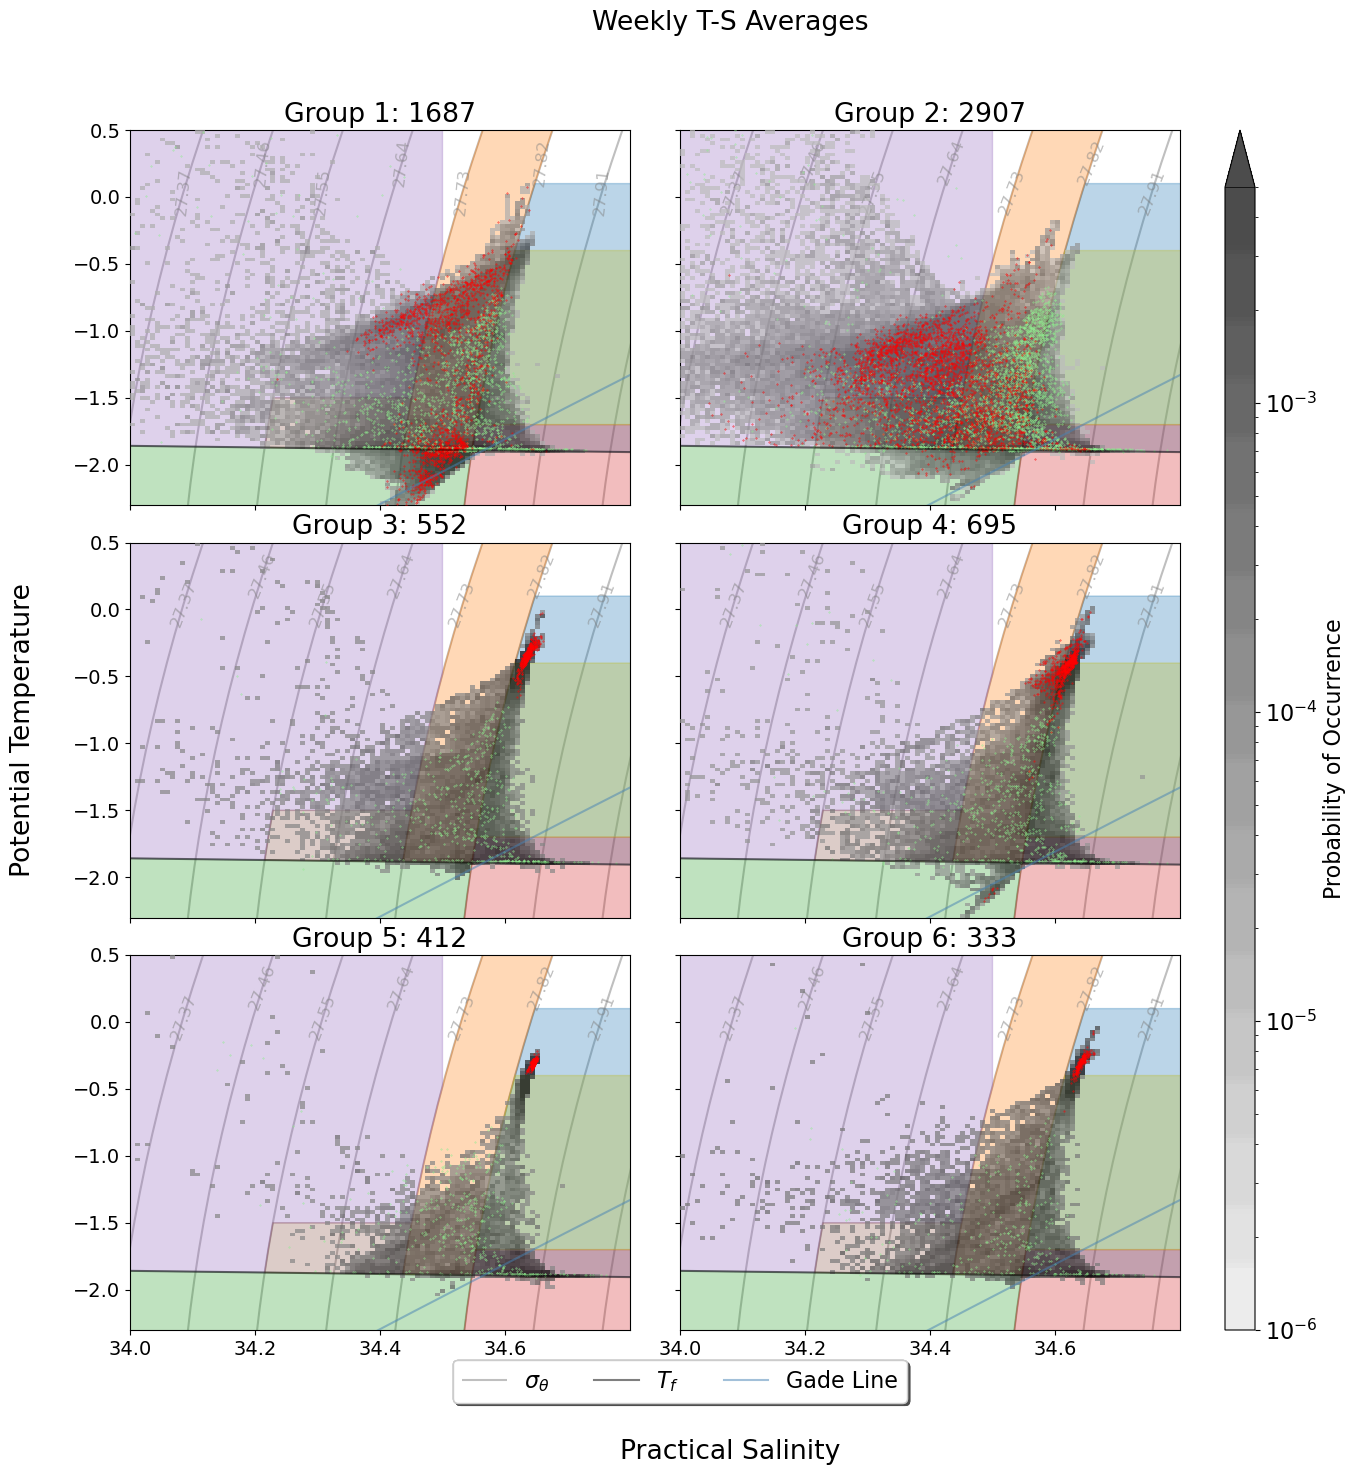

In [156]:
# also try creating a mesh for each of the 6 groups
#fig = plt.figure(figsize=(15,15))
fig, axes = plt.subplots(figsize=(15,15),nrows=3, ncols=2,sharex=True,sharey=True)
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 16})
i = 1

fig.suptitle("Weekly T-S Averages")
fig.supxlabel('Practical Salinity')
fig.supylabel('Potential Temperature')

cmap = plt.get_cmap('gray_r',20).copy()
cmap = truncate_colormap(cmap, 0.1)
cmap.set_under(color='white')

xticks = np.arange(34,34.8,0.2)
yticks = np.arange(0.5,-2.4,-0.5)

for ax,group in zip(axes.flat,groups):
    print(i)
    # make and set the polygons
    shapes = np.array([])
    shapelabels = np.array([])

    # add the potential density lines
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=[27.37,27.46,27.55,27.64,27.73,27.82,27.91,28])
    cl=plt.clabel(cs,fontsize=12,inline=False,fmt="%.2f")
    h, l = cs.legend_elements()
    h = np.array([h[0]],dtype=object)
    l = np.array(["$\sigma_{θ}$"])

    # add the freezing temperature
    fline = ax.plot(si,Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=7)
    gadeline = ax.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=8)
    h = np.append(h,fline)
    l = np.append(l,"$T_{f}$")
    h = np.append(h,gadeline)
    l = np.append(l,"Gade Line")

    # AABW values
    x, y = aabw.exterior.xy
    #aabw2 = plt.plot(x, y,label="AABW",color="tab:blue")
    ax.fill(x, y,alpha=0.3,color="tab:blue")
    shapes = np.append(shapes,aabw2)
    shapelabels = np.append(shapelabels,"AABW*")
    # MCDW values
    x, y = mcdw.exterior.xy
    #mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange")
    ax.fill(x, y,alpha=0.3,color="tab:orange")
    shapes = np.append(shapes,mcdw2)
    shapelabels = np.append(shapelabels,"mCDW")
    # # ISW values
    x, y = isw.exterior.xy
    #isw2 = plt.plot(x, y,label="ISW",color="tab:green")
    ax.fill(x, y,alpha=0.3,color="tab:green")
    shapes = np.append(shapes,isw2)
    shapelabels = np.append(shapelabels,"ISW")
    # # DSW values
    x, y = dsw.exterior.xy
    #dsw2 = plt.plot(x, y,label="DSW",color="tab:red")
    ax.fill(x, y,alpha=0.3,color="tab:red")
    shapes = np.append(shapes,dsw2)
    shapelabels = np.append(shapelabels,"DSW")
    # # MSW values
    x, y = msw.exterior.xy
    #msw2 = plt.plot(x, y,label="mSW*",color="tab:olive")
    ax.fill(x, y,alpha=0.3,color="tab:olive")
    shapes = np.append(shapes,msw2)
    shapelabels = np.append(shapelabels,"mSW*")
    # # AASW values
    x, y = aasw.exterior.xy
    #aasw2 = plt.plot(x, y,label="AASW",color="tab:purple")
    ax.fill(x, y,alpha=0.3,color="tab:purple")
    shapes = np.append(shapes,aasw2)
    shapelabels = np.append(shapelabels,"AASW")
    # # WW values
    x, y = ww.exterior.xy
    #ww2 = plt.plot(x, y,label="WW",color="tab:brown")
    ax.fill(x, y,alpha=0.3,color="tab:brown")
    shapes = np.append(shapes,ww2)
    shapelabels = np.append(shapelabels,"WW")
    # labels and plot
    legend1 = plt.legend(h,l, loc='upper center', bbox_to_anchor=(0, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.gca().add_artist(legend1)
    #ax.legend()
    
    
    #####################################################
    # make and set the density plotting
    ax.set_ylim(-2.3, 0.5)
    ax.set_xlim(34,34.8)
    
    # try to add the clustering
    x = np.mean(salt[:,group].reshape(60,584,len(group)),axis=1).flatten()    # 6 day average
    y = np.mean(temp[:,group].reshape(60,584,len(group)),axis=1).flatten()
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100,range=[[34,34.8], [-2.3, 0.5]])
    C1 = heatmap.T/len(x)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    X = np.linspace(xedges[0], xedges[-1],101)
    Y = np.linspace(yedges[0], yedges[-1],101)
    
    pcm = ax.pcolormesh(X, Y, C1,norm=colors.LogNorm(vmin=1e-6,vmax=0.005),cmap=cmap,alpha=0.7,zorder=5)
    ax.scatter(salt[:,group][0],temp[:,group][0],marker="o",s=0.1,color="lightgreen",zorder=6)
    ax.scatter(salt[:,group][-1],temp[:,group][-1],marker="o",s=0.1,color="red",zorder=6)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # label and plot
    ax.title.set_text("Group " + str(i) + ": " + str(len(group)))
    i += 1
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,wspace=0.1, hspace=0.1)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
fig.colorbar(pcm,extend='max',label="Probability of Occurrence",cax = cb_ax)

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/weekly_mean_subplots3.png", dpi=300)

### Depth vs time mesh

In [99]:
# plot rho with depth
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400
time1 = x_time0.astype(int)

1
2
3
4
5
6


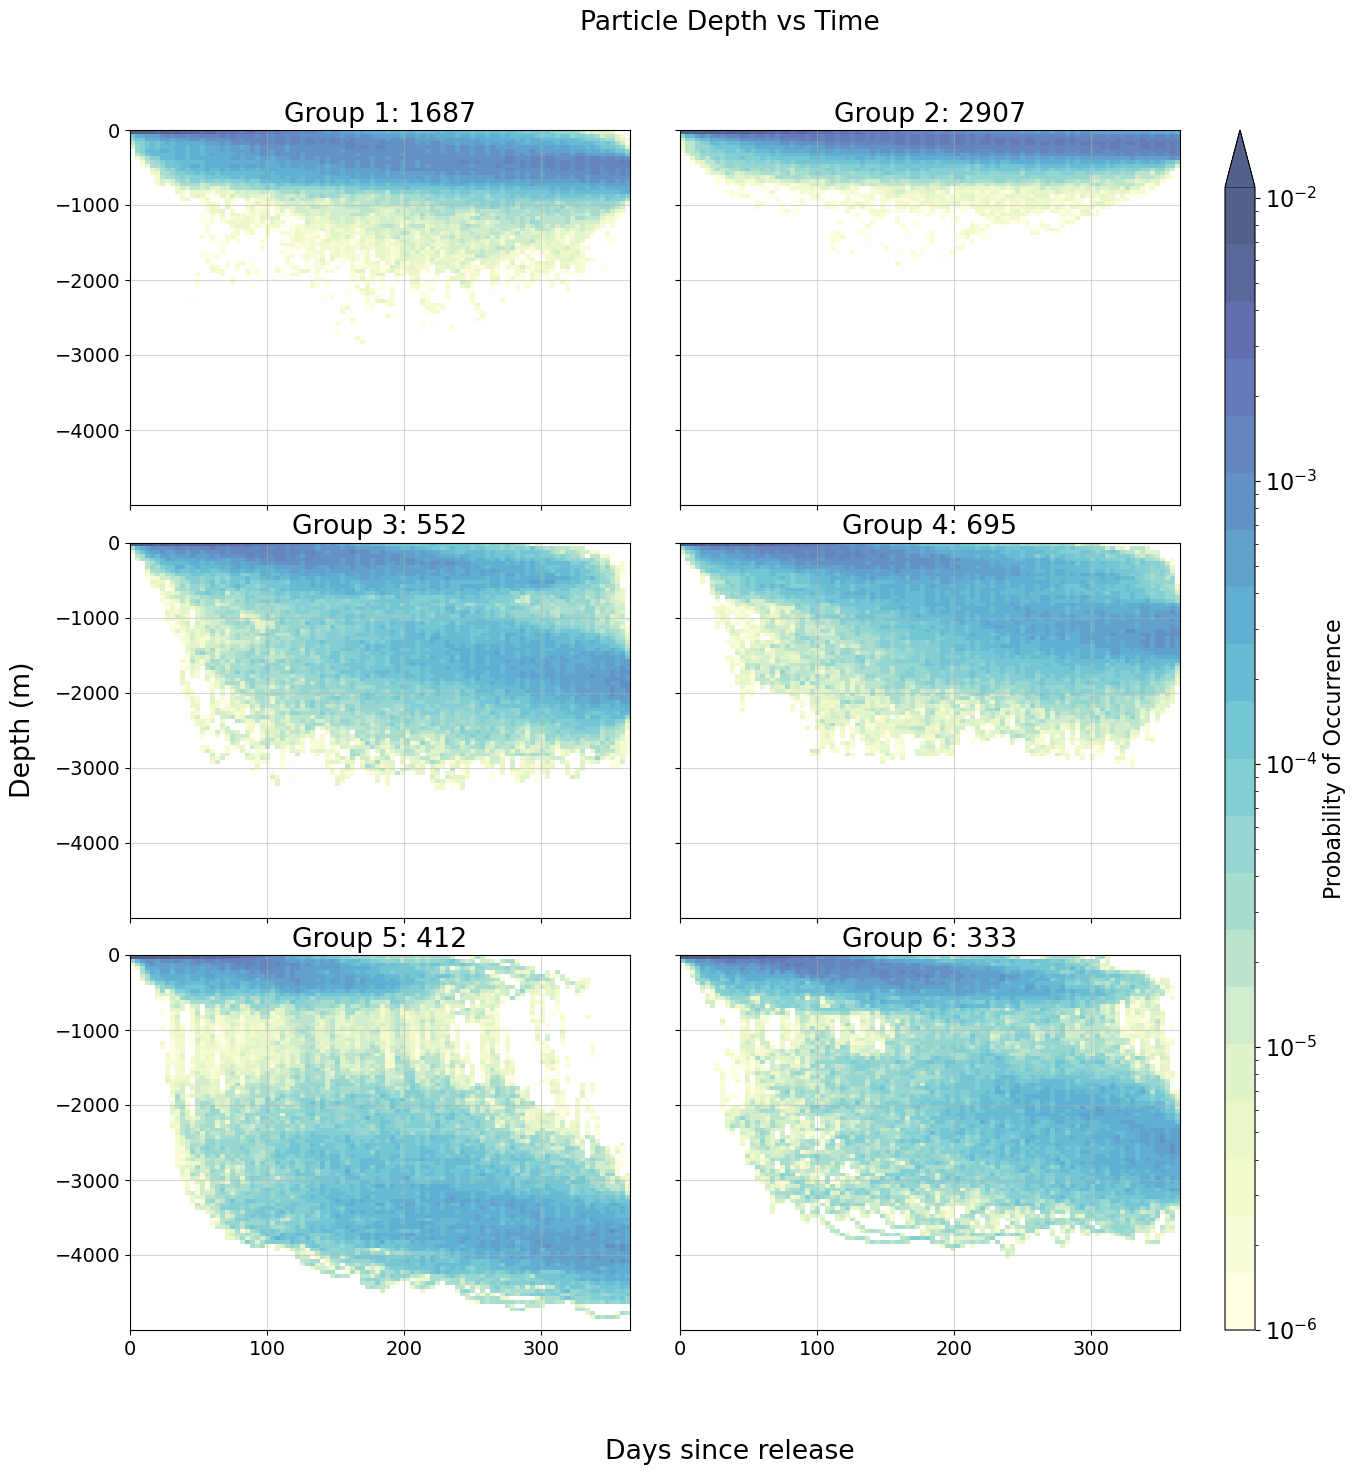

In [100]:
#fig = plt.figure(figsize=(15,15))
fig, axes = plt.subplots(figsize=(15,15),nrows=3, ncols=2,sharex=True,sharey=True)
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 16})
i = 1

fig.suptitle("Particle Depth vs Time")
fig.supxlabel('Days since release')
fig.supylabel('Depth (m)')

cmap = plt.get_cmap('YlGnBu',20).copy()
cmap.set_under(color='white')
xticks = np.arange(0,365,100)
yticks = np.arange(0,-5000,-1000)

for ax,group in zip(axes.flat,groups):
    print(i)
    ax.set_ylim(-5000, 0)
    ax.set_xlim(0,365)
    
    # try to add the clustering
    x = time1[:,group].flatten()
    y = depth[:,group].flatten()
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100,range=[[0,365], [-5000, 0]])
    C1 = heatmap.T/len(x)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    X = np.linspace(xedges[0], xedges[-1],101)
    Y = np.linspace(yedges[0], yedges[-1],101)
    
    pcm = ax.pcolormesh(X, Y, C1,norm=colors.LogNorm(vmin=1e-6,vmax=C1.max()),cmap=cmap,alpha=0.7)
    #pcm = ax.pcolormesh(X, Y, C1,cmap=cmap,alpha=0.7,vmin=0.0001,vmax=0.005)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # label and plot
    ax.title.set_text("Group " + str(i) + ": " + str(len(group)))
    ax.grid(alpha=0.5)
    i += 1
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,wspace=0.1, hspace=0.1)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
fig.colorbar(pcm,extend='max',label="Probability of Occurrence",cax = cb_ax)

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/rho_over_time.png", dpi=300)

### rho vs depth mesh

1
2
3
4
5
6


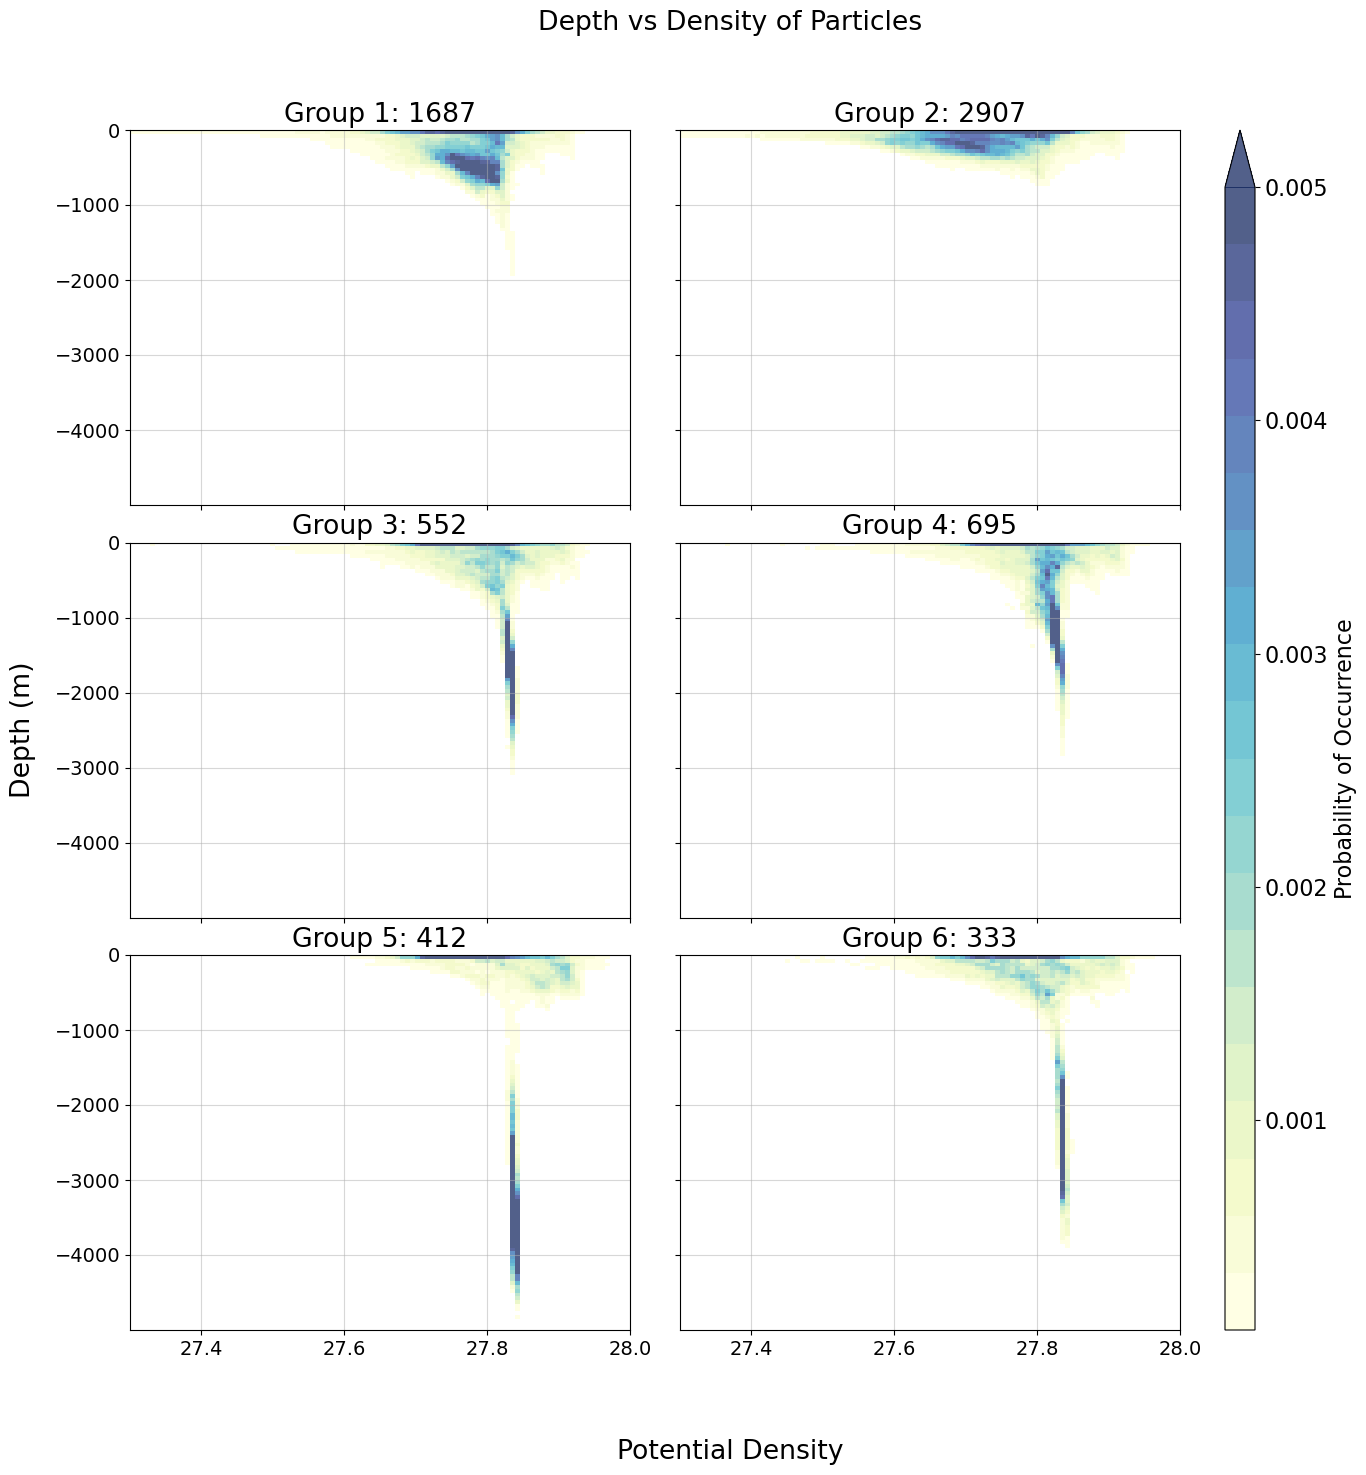

In [103]:
# plot rho with depth
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400
time1 = x_time0.astype(int)

#fig = plt.figure(figsize=(15,15))
fig, axes = plt.subplots(figsize=(15,15),nrows=3, ncols=2,sharex=True,sharey=True)
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 16})
i = 1

fig.suptitle("Depth vs Density of Particles")
fig.supxlabel('Potential Density')
fig.supylabel('Depth (m)')

cmap = plt.get_cmap('YlGnBu',20).copy()
cmap.set_under(color='white')
xticks = np.arange(27.4,28,0.2)
yticks = np.arange(0,-5000,-1000)

for ax,group in zip(axes.flat,groups):
    print(i)
    plt.ylim(-5000, 0)
    plt.xlim(27.3,28)
    
    # try to add the clustering
    x = rho_pot0[:,group].flatten()
    y = depth[:,group].flatten()
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100,range=[[27.3, 28], [-5000, 0]])
    C1 = heatmap.T/len(x)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    X = np.linspace(xedges[0], xedges[-1],101)
    Y = np.linspace(yedges[0], yedges[-1],101)
    
    #pcm = ax.pcolormesh(X, Y, C1,norm=colors.LogNorm(vmin=1e-6,vmax=C1.max()),cmap=cmap,alpha=0.7)
    pcm = ax.pcolormesh(X, Y, C1,cmap=cmap,alpha=0.7,vmin=0.0001,vmax=0.005)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # label and plot
    ax.title.set_text("Group " + str(i) + ": " + str(len(group)))
    ax.grid(alpha=0.5)
    i += 1
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,wspace=0.1, hspace=0.1)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
fig.colorbar(pcm,extend='max',label="Probability of Occurrence",cax = cb_ax)

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/rho_vs_depth_polynya.png", dpi=300)

### Seasonal dist of particles

In [112]:
pollocs2 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/pollocs_forseasons.txt",sep=",",dtype=int)
pollocs2.shape

(6586,)

In [113]:
# seasonal distributions of the groups
# this says months but really it is a distribution of them by 13 4-week intervals
# find the repeating releases for each of the 105 points
month_idx = np.arange(0,52) #(13,8760)
x = 0
m = 1
for i in range(len(month_idx)):
    month_idx[i] = m
    
    x += 1
    if x == 4:
        x = 0
        m += 1
# repeat this for the 105 points
df_months_i = np.array([],dtype=int)
for i in range(391):
    df_months_i = np.append(df_months_i,month_idx)

unique, counts = np.unique(df_months_i, return_counts=True)
print(unique,counts)
df_months_i = df_months_i[pollocs2]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13] [1564 1564 1564 1564 1564 1564 1564 1564 1564 1564 1564 1564 1564]


In [114]:
df_months_i

array([5, 5, 6, ..., 9, 9, 9])

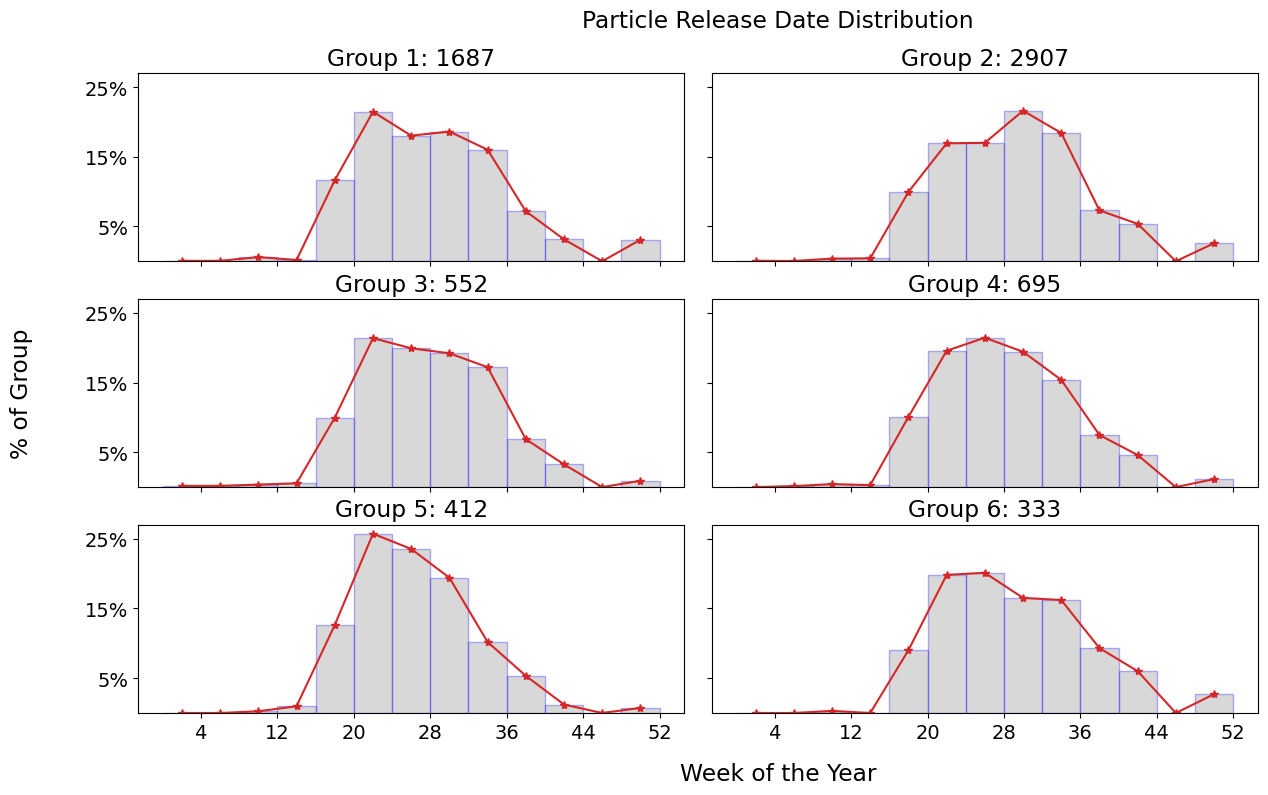

In [124]:
# # Distribution of Various Quantities
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm

#fig = plt.figure(figsize = (16,8))

fig, axes = plt.subplots(figsize=(16,8),nrows=3, ncols=2,sharex=True,sharey=True)

plt.tight_layout()
plt.rcParams.update({'font.size': 14})
plt.suptitle("Particle Release Date Distribution")
fig.supxlabel('Week of the Year')
fig.supylabel('% of Group')
i = 1
xticks=[2,4,6,8,10,12,14]
yticks=[0.05,0.15,0.25]

for ax,group in zip(axes.flat,groups):
    y,edges,_ = ax.hist(df_months_i[group],alpha=0.3,edgecolor="blue",facecolor="gray",bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14],weights=np.ones(len(df_months_i[group])) / len(df_months_i[group]))
    mystr = "Group " + str(i) + ": " + str(len(group))
    #plt.xticks(ticks=[2,4,6,8,10,12,14],labels=[4,12,20,28,36,44,52])
    #ax.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.xticks()
    
    ax.title.set_text(mystr)
    ax.set_xticks(xticks,labels=[4,12,20,28,36,44,52])
    ax.set_yticks(yticks,labels=["5%","15%","25%"])
    
    i  += 1
    
    #y,edges,_ = plt.hist(test_scores1, bins)
    xcenters = (edges[:-1] + edges[1:]) / 2
    #y,edges = np.histogram(df_months_i[group], bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    #centers = 0.5*(edges[1:]+ edges[:-1])
    ax.plot(xcenters,y,'-*',color="tab:red")
    
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,wspace=0.05, hspace=0.2)
    
plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/months_dist_perc.png", dpi=300)

### Eulerian view of particles

In [15]:
stack = np.stack((ygrid, xgrid), axis=-1)
lat2 = interpn((ybins,xbins),lat_values,stack)
long2 = interpn((ybins,xbins),long_values,stack)

0
1
2
3
4
5


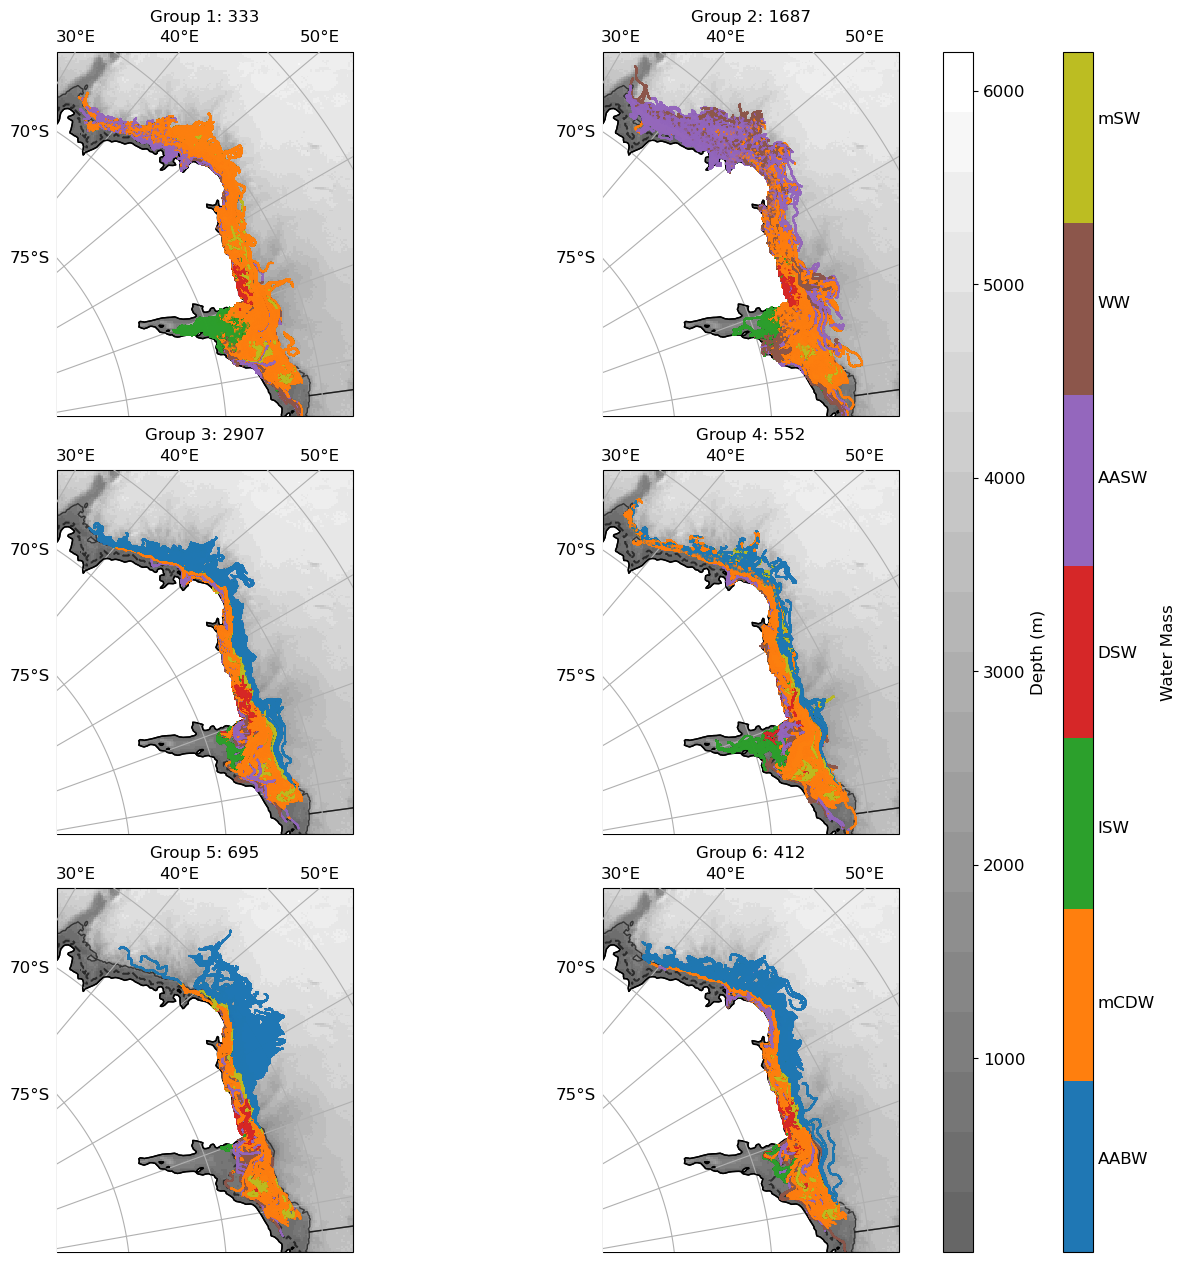

In [16]:
# THESE ARE IN GRID POINTS
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')

fig, axes = plt.subplots(figsize=(15,15),nrows=3, ncols=2,sharex=True,sharey=True,subplot_kw={'projection': proj})
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 12})
i = 0

idx = np.arange(1,7,1)

cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:olive"])
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]

for ax,group in zip(axes.flat,groups):
    print(i)

    ax.title.set_text("Group " + str(i+1) + ": "+ str(len(groups[i-1])))
    pcm = ax.scatter(long2[:,groups[i]],lat2[:,groups[i]],marker='.',s=0.1,zorder=10,
                c=wmt[:,groups[i]],cmap=cmap,transform=ccrs.PlateCarree(),rasterized=True)
    
    cm_d = ax.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),
                         cmap=plt.get_cmap('gray',20),alpha=0.6)
    ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
    
    # add ice shelf and continental shelf
    ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.6)
    ax.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.2],
            zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=plt.get_cmap('gray'),alpha=0.6)
    
    # add the colorbar and lat/long ticks
    #cbar = plt.colorbar(label="Bathymetry (m)",extend='max',location='left')
    gl = ax.gridlines(zorder=3,draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.rotate_labels = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,edgecolor='black', facecolor='white',zorder=3)
    plt.xlim([1250000,3000000])
    plt.ylim([200000,2350000])
    
    i += 1
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.78,wspace=0.15, hspace=0.15)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(pcm,label="Water Mass",cax = cb_ax,ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
cbar.ax.tick_params(labelsize=12, length=0)

bounds = np.array([0,1,2,3,4,5])
# cbar.set_ticks([0.5,1.3,2.175,3.05,3.925,4.8,5.675])
cbar.set_ticks([0.5,1.25,2.125,3,3.875,4.75,5.625])
tick_texts = cbar.ax.set_yticklabels(labels)
tick_texts[0].set_verticalalignment('top')
tick_texts[-1].set_verticalalignment('bottom')

cb_ax2 = fig.add_axes([0.75,0.1,0.02,0.8])
cbar2 = fig.colorbar(cm_d,label="Depth (m)",cax = cb_ax2)

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_7/wmt_colored_remade2.png", dpi=300)

In [177]:
# # THESE ARE IN GRID POINTS
# # plot all the groups colored by the water mass grid
# proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
# fig = plt.figure(figsize=(15,15))

# idx = np.arange(1,7,1)

# cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:olive"])
# labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]

# for i in idx:
#     print(i)
    
#     ax = fig.add_subplot(2, 3, i,projection=proj)
#     plt.rcParams.update({'font.size': 15})
#     plt.title("Group " + str(i) + ": "+ str(len(groups[i-1])))
#     plt.scatter(long2[:,groups[i-1]],lat2[:,groups[i-1]],marker='.',s=0.1,zorder=10,
#                 c=wmt[:,groups[i-1]],cmap=cmap,transform=ccrs.PlateCarree(),rasterized=True)
    
#     cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
#     cbar.ax.set_yticklabels(labels)
#     plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
#     plt.grid()
#     ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
#     cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],
#                      levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
    
#     # latlong ticks
#     gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
#     gl.rotate_labels = False
#     gl.ylabels_right = False
#     gl.xlines = True
#     gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
#     gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
#     plt.xlim([1250000,3050000])
#     plt.ylim([250000,2350000])
    
# plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_6_1/wmt_colored2.png", dpi=300)